# Predicting Power Plant Electrical Energy Output

This notebook contains the documented code for the prediction of electrical energy output of a power plant via two different models and a baseline. The dataset used is from a combined cycle power plant and taken over 6 years. 

Since we have labelled data where target values fall on a spectrum, we will use regression techniques for our algorithms. Classification would only be appropriate in the case that target values were a discrete set of options. Clustering would only be appropriate if the data where unlabelled, and partionable into distinct groups. 

##IMPORTANT NOTE: manual action required on code block 2: Upload Dataset

## Import Libraries
The following block imports the relevant libraries.

In [5]:
from google.colab import files
import pandas as pd
import numpy as np
import math
from scipy.stats import norm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold




# **Upload Dataset**
**IMPORTANT**: Run this code and click the **Choose files** button which appears. Select the **plantdata.csv** from your local files. Let this upload finish before moving on. 

## Runtime -> Run all will not complete until this file is selected manually.

In [7]:
# Select the "plantdata.csv" file for our dataset, upload it from your
# local files. 
uploaded = files.upload()

Saving coursework_other.csv to coursework_other (1).csv


In [8]:
# Read the dataframe with pandas.
df = pd.read_csv('plantdata.csv')

# Separate the feature variables from the target PE. 
data = df.drop('PE', axis=1) 
target = df['PE']

# print(data)
# print(target)

In [9]:
# Separate the data and targets into training and testing sets. 
xtrain, xtest, ytrain, ytest = train_test_split(data, target, test_size=0.2)

# Baseline Model 
We will use the `Sklearn.dummy` module to generate a baseline regression algorithm for this data.

In [10]:
# create the dummy regressor
dummy = DummyRegressor(strategy='mean') # from testing, mean outperforms median.
# fit it to the training data
dummy.fit(xtrain, ytrain)
# find the prediction on the test data
dummy_pred = dummy.predict(xtest)

In [11]:
# Investigate the MSE and R squared values by comparing to the test targets.

dummy_mse = mean_squared_error(ytest, dummy_pred)
dummy_rSquared = r2_score(ytest, dummy_pred)

print("MSE: ", dummy_mse)
print("r squared: ",round(dummy_rSquared,3))

"""
The closer R squared is to 1, the better the regression line fits the actual 
test targets. As expected, R squared comes out as zero for the baseline here as 
the baseline simply uses the mean value. This means R squared = 1 - 1 = 0, for 
this algorithm.


"""

MSE:  281.2478387793785
r squared:  -0.0


'\nThe closer R squared is to 1, the better the regression line fits the actual \ntest targets. As expected, R squared comes out as zero for the baseline here as \nthe baseline simply uses the mean value. This means R squared = 1 - 1 = 0, for \nthis algorithm.\n\n\n'

'\nBeing below the line means the predictions overestimated the target value.\nBeing above the line means the predictions underestimated the target vlaue.\n'

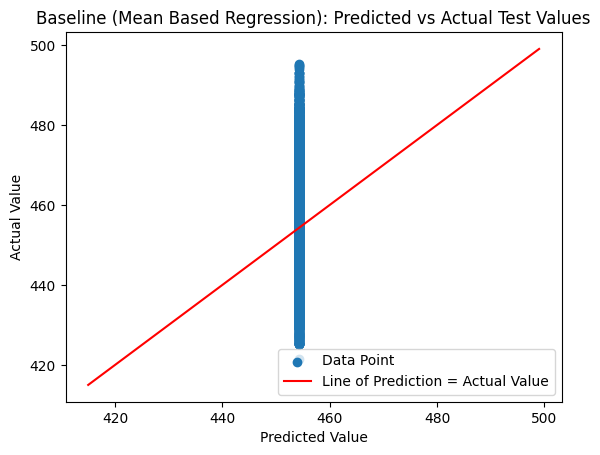

In [12]:
# Plot predicted values vs target values on a scatter plot, and drawing a line y=x

xline = list(range(415,500))
yline = xline

fig, RegTraining = plt.subplots() # This generates us a named figure and axes
RegTraining.scatter(dummy_pred, ytest, label = 'Data Point') # We generate a scatterplot of the data on the axes.
RegTraining.plot(xline, yline, label = 'Line of Prediction = Actual Value', color = 'red')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Baseline (Mean Based Regression): Predicted vs Actual Test Values')
plt.legend()

"""
Being below the line means the predictions overestimated the target value.
Being above the line means the predictions underestimated the target vlaue.
"""

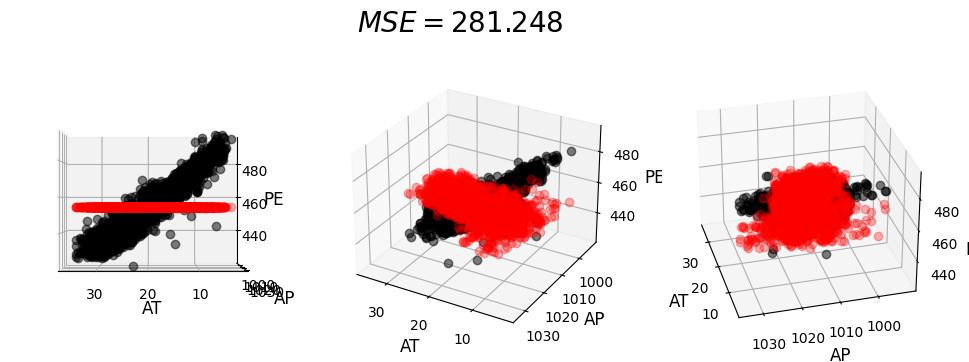

In [13]:
# Looking at how the prediction maps to the targets across multiple features. 
# We can use 3D plots to map two features and the Electrical Energy Output, on
# A single figure.

# Select two of four feature variables by dropping the other two. 
# I have chosen Ambient Pressure (AP) and Temperature (AT)
reduced_data = xtest.drop('RH', axis=1)
reduced_data = reduced_data.drop('V', axis=1)

# reshape  the data so we can split it in the next segment.
X = reduced_data.values.reshape(-1,2)


x = X[:, 0] # x axis is ambient temperature
y = X[:, 1] # y axis is ambient pressure
z = ytest # z axis is energy output






# Create a figure with three subplots
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

views = [ax1, ax2, ax3]
# plot the target values (grey) and the predictions (red).
for ax in views:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.plot(x, y, dummy_pred, color='r', zorder=15, linestyle='none', marker='o', alpha=0.3)
    ax.set_xlabel('AT', fontsize=12)
    ax.set_ylabel('AP', fontsize=12)
    ax.set_zlabel('PE', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
# use different perspectives for each sub plot.
ax1.view_init(elev=0, azim=90)
ax2.view_init(elev=28, azim=120)
ax3.view_init(elev=30, azim=165)

# display the mean squared error of the algorithm. 
fig.suptitle('$MSE = %.3f$' % dummy_mse, fontsize=20)
fig.subplots_adjust(wspace=0.175)
fig.show()

# Linear Regression

In [14]:
# First we add a column of ones to our data for the intercept term. 

# Check the shape of our data in train and test sets
print('Current Shape: ')
print(np.shape(xtrain))
print(np.shape(xtest))

# Add the column of ones 
x_train = np.c_[xtrain, np.ones(7654)]
x_test = np.c_[xtest, np.ones(1914)]

# Then check the shape has increased by one column.
print('\nShape after adding column of ones: ')
print(np.shape(x_train))
print(np.shape(x_test))

Current Shape: 
(7654, 4)
(1914, 4)

Shape after adding column of ones: 
(7654, 5)
(1914, 5)


For linear regression, we assume: 
$$ \hat{\vec{y}} = X\Theta$$
Where $\hat{\vec{y}}$ is our target array and $X$ is our data array. We use the training data to find an array for $\Theta$ and test this on the held out test data set for comparison with `ytest`

$\Theta$ can be found with: 
$$ \Theta = (X^T X)^{-1} X^T \vec{y}$$

Where $(X^T X)^{-1} X^T$ is the psuedoinverse of $X$. We need to ensure we perform matrix multiplication rather than element level multiplication to acquire the correct $\Theta$ array. 

In [15]:
# Calculating Theta array, using the training data.

# Find pseudo inverse of X
pseudo_inv = np.linalg.pinv(x_train)

# Matrix multiply pseudo inverse with training targets.
theta = np.matmul(pseudo_inv,ytrain)
print('Theta consists of 5 coefficients which multiply the data with the aim of acquiring the target: ')
print(theta)


Theta consists of 5 coefficients which multiply the data with the aim of acquiring the target: 
[-1.96734625e+00 -2.38835308e-01  6.22948424e-02 -1.56567878e-01
  4.54387429e+02]


In [16]:
# Use theta to make a prediction on the test data:
LinReg_pred = np.matmul(x_test,theta)

In [17]:
# Investigate the MSE and R squared values by comparing to the test targets.

LinReg_mse = mean_squared_error(ytest, LinReg_pred)
LinReg_rSquared = r2_score(ytest, LinReg_pred)

print("MSE: ", LinReg_mse)
print("r squared: ", LinReg_rSquared)

"""
We can see the mean squared error here is much lower compared to the simple
baseline algorithm, which just takes the mean of the training targets as its
prediction 

The closer R squared is to 1, the better the regression line fits the actual 
test targets.
"""

MSE:  21.576291203963983
r squared:  0.9232780753716755


'\nWe can see the mean squared error here is much lower compared to the simple\nbaseline algorithm, which just takes the mean of the training targets as its\nprediction \n\nThe closer R squared is to 1, the better the regression line fits the actual \ntest targets.\n'

'\nBeing below the line means the predictions overestimated the target value.\nBeing above the line means the predictions underestimated the target vlaue.\n'

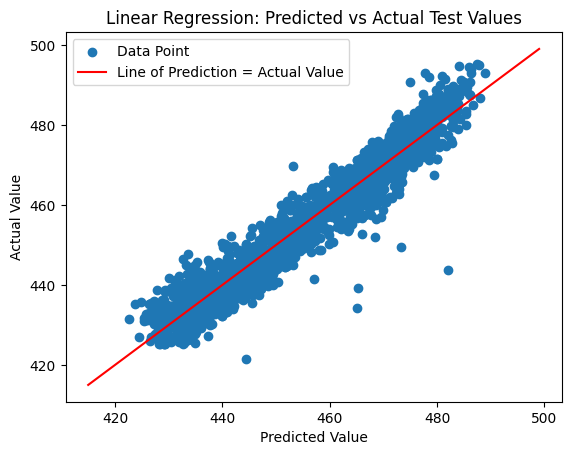

In [18]:
# Plot predicted values vs target values on a scatter plot, and drawing a line y=x

xline = list(range(415,500))
yline = xline

fig, RegTraining = plt.subplots() # This generates us a named figure and axes
RegTraining.scatter(LinReg_pred, ytest, label = 'Data Point') # We generate a scatterplot of the data on the axes.
RegTraining.plot(xline, yline, label = 'Line of Prediction = Actual Value', color = 'red')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Linear Regression: Predicted vs Actual Test Values')
plt.legend()

"""
Being below the line means the predictions overestimated the target value.
Being above the line means the predictions underestimated the target vlaue.
"""

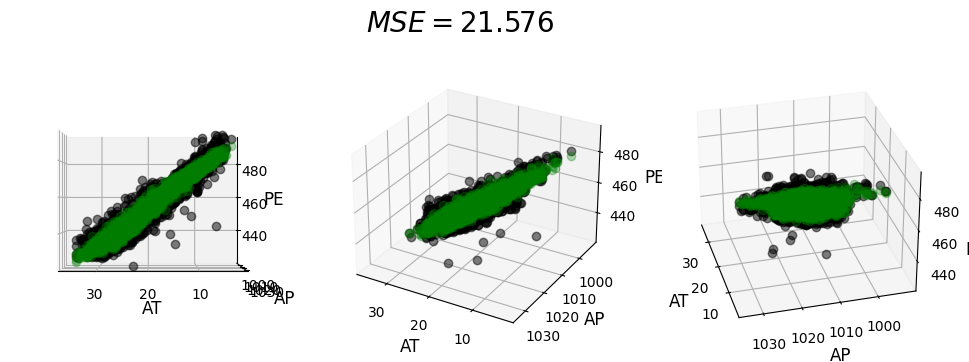

In [19]:
# Looking at how the prediction maps to the targets across multiple features. 
# We can use 3D plots to map two features and the Electrical Energy Output, on
# A single figure.

# Select two of four feature variables by dropping the other two. 
# I have chosen Ambient Pressure (AP) and Temperature (AT)
reduced_data = xtest.drop('RH', axis=1)
reduced_data = reduced_data.drop('V', axis=1)

# reshape  the data so we can split it in the next segment.
X = reduced_data.values.reshape(-1,2)


x = X[:, 0] # x axis is ambient temperature
y = X[:, 1] # y axis is ambient pressure
z = ytest # z axis is energy output






# Create a figure with three subplots
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

views = [ax1, ax2, ax3]
# plot the target values (grey) and the predictions (red).
for ax in views:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.plot(x, y, LinReg_pred, color='g', zorder=15, linestyle='none', marker='o', alpha=0.3)
    ax.set_xlabel('AT', fontsize=12)
    ax.set_ylabel('AP', fontsize=12)
    ax.set_zlabel('PE', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
# use different perspectives for each sub plot.
ax1.view_init(elev=0, azim=90)
ax2.view_init(elev=28, azim=120)
ax3.view_init(elev=30, azim=165)

# display the mean squared error of the algorithm. 
fig.suptitle('$MSE = %.3f$' % LinReg_mse, fontsize=20)
fig.subplots_adjust(wspace=0.175)
fig.show()

# KNN Regression

For KNN regression, the number of nearest neighbours average between is the only hyperparameter. This is because it cannot be learned directly from the data. 

to do: 

copy w 13/14 ws content think about analysis beyond MSE -> acc precision etc -> need to justify choice on which one you choose. 

In [20]:
# We need to reformat the data into nested lists for our cross-validation

xtrain_reformatted = xtrain.values
ytrain_reformatted = ytrain.values
print(xtrain_reformatted)
print(ytrain_reformatted)


[[  10.38   43.02 1013.37   78.53]
 [   9.48   40.11 1025.49   73.81]
 [  29.54   69.48 1008.91   56.07]
 ...
 [  29.03   69.51 1009.8    47.04]
 [  26.23   63.56 1013.57   65.81]
 [  29.36   68.94 1007.5    79.91]]
[474.44 472.16 427.82 ... 435.09 440.8  431.39]


Currently plotting  1 /6:  uniform  weights with ball_tree  algorithm.
Currently plotting  2 /6:  uniform  weights with kd_tree  algorithm.
Currently plotting  3 /6:  uniform  weights with brute  algorithm.
Currently plotting  4 /6:  distance  weights with ball_tree  algorithm.
Currently plotting  5 /6:  distance  weights with kd_tree  algorithm.
Currently plotting  6 /6:  distance  weights with brute  algorithm.


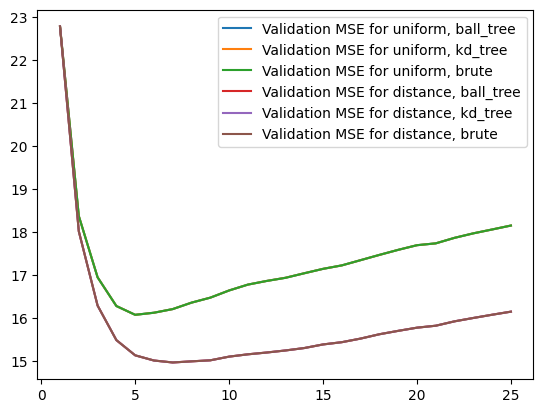

{'uniform, ball_tree': 16.074310532293048, 'uniform, kd_tree': 16.074310532293048, 'uniform, brute': 16.074431821181935, 'distance, ball_tree': 14.964450330826, 'distance, kd_tree': 14.964450330826, 'distance, brute': 14.964450330873513}
Lowest MSE is given by:  distance, ball_tree


In [28]:

# Here we choose the other hyper-parameters of weight and algorithm
# This is done by finding which provides the lowest MSE across a range of K values
# we use the kfolds module, spliting the training data into five fold. 
my_random_state = 16
kf = KFold(n_splits=5, shuffle= True, random_state= my_random_state)

split_data = kf.split(xtrain_reformatted,ytrain_reformatted)

# we will test k between k = 1 - 25
max_k = 25



wts = ['uniform', 'distance']
alg = ['ball_tree', 'kd_tree', 'brute']
counter = 1
lowestMSE = {}

for i in wts:
  for j in alg:
    # prepare lists to store MSE and Rsquared for each iteration
    tr_mse_list = [[] for _ in range(max_k)]
    val_mse_list = [[] for _ in range(max_k)]

    tr_r2_list = [[] for _ in range(max_k)]
    val_r2_list = [[] for _ in range(max_k)]

    # counter as takes time to load
    
    print('Currently plotting ', counter, '/6: ',i , ' weights with', j, ' algorithm.')
    counter += 1
    # prepare figures to plot results to
    x_axis = list(range(1,max_k+1)) # range goes to one less than the number put in.

    # Loop over the values of k: 
    for k in range(max_k):
        
        current_regressor =  KNeighborsRegressor(n_neighbors = k+1, weights = i, algorithm = j)
        
        # Loop over the cross-validation splits: 
        for t, v in kf.split(xtrain_reformatted):
            Xtrain, Xval = xtrain_reformatted[t], xtrain_reformatted[v]
            Ytrain, Yval = ytrain_reformatted[t], ytrain_reformatted[v]

            # fit the model on the current split of data 
            current_regressor.fit(Xtrain,Ytrain)

            # make predictions 
            val_pred = current_regressor.predict(Xval)

            # calculate validation mean squared error
            # store these in the preset list
            val_mse_list[k].append(mean_squared_error(Yval,val_pred))
            

 
    # find the mean of the MSEs and Rsquared across the 5 folds. 
    mean_val_mses = np.mean(val_mse_list, axis = 1)





    plt.plot(x_axis, mean_val_mses, label = f'Validation MSE for {i}, {j}')
    lowestMSE[f'{i}, {j}'] = min(mean_val_mses)

# Plot the MSE scores against K for each set of weights and algorithm
plt.legend()
plt.show()

# Show the dictionary containing the minimum MSEs for each 
print(lowestMSE)
# Show the algorithm and weight providing the overall minimum
print('Lowest MSE is given by: ', min(lowestMSE, key = lowestMSE.get))

# Asign these optimal hyper-parameters to variables to use later.
extractOptima = str.split(min(lowestMSE, key = lowestMSE.get),',')
optimalWeight = extractOptima[0].strip() 
optimalAlgorithm = extractOptima[1].strip()

MSE and Rsquared Agree, Optimum number of neighbours:  7


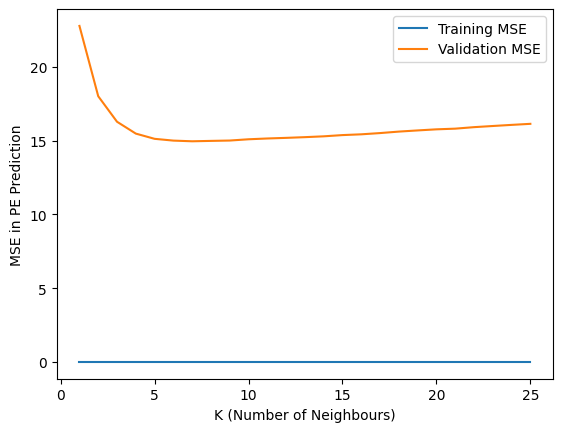

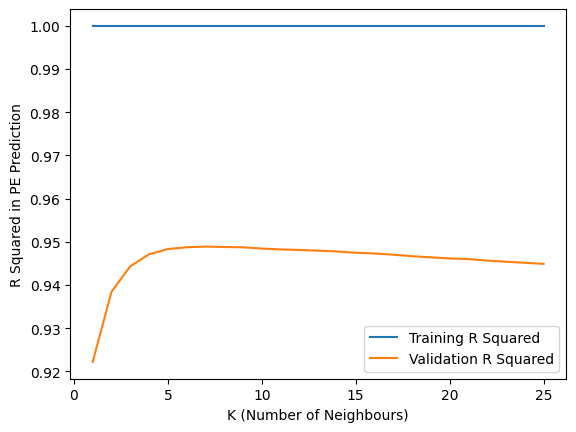

In [22]:
# Now we repeat the cross validation with our optimal weight and algorithm parameters
# This time we select the optimal number of neighbours, k

# we use the kfolds module, spliting the training data into five fold. 
my_random_state = 16
kf = KFold(n_splits=5, shuffle= True, random_state= my_random_state)

split_data = kf.split(xtrain_reformatted,ytrain_reformatted)

# we will test k between k = 1 - 25
max_k = 25

# prepare lists to store MSE and Rsquared for each 
tr_mse_list = [[] for _ in range(max_k)]
val_mse_list = [[] for _ in range(max_k)]

tr_r2_list = [[] for _ in range(max_k)]
val_r2_list = [[] for _ in range(max_k)]
# Loop over the values of k: 
for k in range(max_k):
    
    current_regressor =  KNeighborsRegressor(n_neighbors = k+1, weights = optimalWeight, algorithm = optimalAlgorithm)
    
    # Loop over the cross-validation splits: 
    for t, v in kf.split(xtrain_reformatted):
        Xtrain, Xval = xtrain_reformatted[t], xtrain_reformatted[v]
        Ytrain, Yval = ytrain_reformatted[t], ytrain_reformatted[v]
        
        # fit the model on the current split of data 
        current_regressor.fit(Xtrain,Ytrain)

        # make predictions 
        tr_pred = current_regressor.predict(Xtrain)
        val_pred = current_regressor.predict(Xval)

        # calculate training and validation mean squared error and rsquared
        # store these in the preset lists
         
        tr_mse_list[k].append(mean_squared_error(Ytrain,tr_pred))
        val_mse_list[k].append(mean_squared_error(Yval,val_pred))
        
        tr_r2_list[k].append(r2_score(Ytrain,tr_pred))
        val_r2_list[k].append(r2_score(Yval,val_pred))
 
# find the mean of the MSEs and Rsquared across the 5 folds. 
mean_tr_mses = np.mean(tr_mse_list, axis = 1)
mean_val_mses = np.mean(val_mse_list, axis = 1)

mean_tr_r2s = np.mean(tr_r2_list, axis = 1)
mean_val_r2s = np.mean(val_r2_list, axis = 1)
# print(mean_tr_mses)
# print(mean_val_mses)
# print(mean_val_r2s)

x_axis = list(range(1,max_k+1)) # range goes to one less than the number put in.
fig, kfoldsMSE = plt.subplots() # This generates us a named figure and axes
kfoldsMSE.plot(x_axis, mean_tr_mses, label = 'Training MSE')
kfoldsMSE.plot(x_axis, mean_val_mses, label = 'Validation MSE')
plt.xlabel('K (Number of Neighbours)')
plt.ylabel('MSE in PE Prediction')
plt.legend()

fig, kfoldsr2 = plt.subplots() # This generates us a named figure and axes
kfoldsr2.plot(x_axis, mean_tr_r2s, label = 'Training R Squared')
kfoldsr2.plot(x_axis, mean_val_r2s, label = 'Validation R Squared')
plt.xlabel('K (Number of Neighbours)')
plt.ylabel('R Squared in PE Prediction')
plt.legend()

# output the optimum number of neighbours according to mse and r squared
optimum_k_mse = np.argmin(mean_val_mses) + 1 # +1 as arrays index from 0 not one
# print(optimum_k_mse)

optimum_k_r2 = np.argmax(mean_val_r2s) + 1 # +1 as arrays index from 0 not one
# print(optimum_k_r2)

# check whether they agree - disagreement implies mathematical error.
if optimum_k_mse == optimum_k_r2:
  print("MSE and Rsquared Agree, Optimum number of neighbours: ", optimum_k_mse)
else:
  print("MSE and Rsquared Do Not Agree. This implies an error as R squared formula is derivable from MSE formula.")

## Following hyperparameter optimisation, we can now create our optimal KNN regressor, fit it and make predictions.

In [23]:
knnReg = KNeighborsRegressor(n_neighbors=optimum_k_mse, weights = optimalWeight, algorithm = optimalAlgorithm)
knnReg.fit(xtrain,ytrain)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7, weights='distance')

In [24]:
knnReg_pred = knnReg.predict(xtest)

# Investigate the MSE and R squared values by comparing to the test targets.

knnReg_mse = mean_squared_error(ytest, knnReg_pred)
knnReg_rSquared = r2_score(ytest, knnReg_pred)

print("MSE: ", knnReg_mse)
print("r squared: ", knnReg_rSquared)

"""
We can see the mean squared error here is much lower compared to the simple
baseline algorithm, which just takes the mean of the training targets as its
prediction 

The closer R squared is to 1, the better the regression line fits the actual 
test targets.
"""


MSE:  15.42242710784205
r squared:  0.9451602558118838


'\nWe can see the mean squared error here is much lower compared to the simple\nbaseline algorithm, which just takes the mean of the training targets as its\nprediction \n\nThe closer R squared is to 1, the better the regression line fits the actual \ntest targets.\n'

'\nBeing below the line means the predictions overestimated the target value.\nBeing above the line means the predictions underestimated the target vlaue.\n'

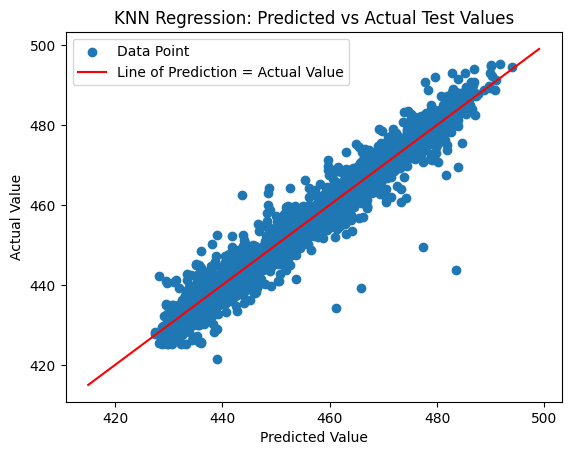

In [25]:
# Plot predicted values vs target values on a scatter plot, and drawing a line y=x

xline = list(range(415,500))
yline = xline

fig, RegTraining = plt.subplots() # This generates us a named figure and axes
RegTraining.scatter(knnReg_pred, ytest, label = 'Data Point') # We generate a scatterplot of the data on the axes.
RegTraining.plot(xline, yline, label = 'Line of Prediction = Actual Value', color = 'red')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('KNN Regression: Predicted vs Actual Test Values')
plt.legend()

"""
Being below the line means the predictions overestimated the target value.
Being above the line means the predictions underestimated the target vlaue.
"""

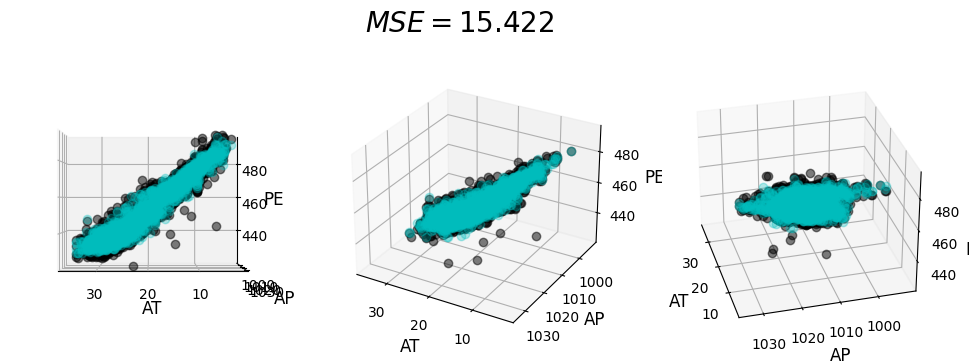

In [26]:
# Looking at how the prediction maps to the targets across multiple features. 
# We can use 3D plots to map two features and the Electrical Energy Output, on
# A single figure.

# Select two of four feature variables by dropping the other two. 
# I have chosen Ambient Pressure (AP) and Temperature (AT)
reduced_data = xtest.drop('RH', axis=1)
reduced_data = reduced_data.drop('V', axis=1)

# reshape  the data so we can split it in the next segment.
X = reduced_data.values.reshape(-1,2)


x = X[:, 0] # x axis is ambient temperature
y = X[:, 1] # y axis is ambient pressure
z = ytest # z axis is energy output






# Create a figure with three subplots
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

views = [ax1, ax2, ax3]
# plot the target values (grey) and the predictions (red).
for ax in views:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.plot(x, y, knnReg_pred, color='c', zorder=15, linestyle='none', marker='o', alpha=0.3)
    ax.set_xlabel('AT', fontsize=12)
    ax.set_ylabel('AP', fontsize=12)
    ax.set_zlabel('PE', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
# use different perspectives for each sub plot.
ax1.view_init(elev=0, azim=90)
ax2.view_init(elev=28, azim=120)
ax3.view_init(elev=30, azim=165)

# display the mean squared error of the algorithm. 
fig.suptitle('$MSE = %.3f$' % knnReg_mse, fontsize=20)
fig.subplots_adjust(wspace=0.175)
fig.show()

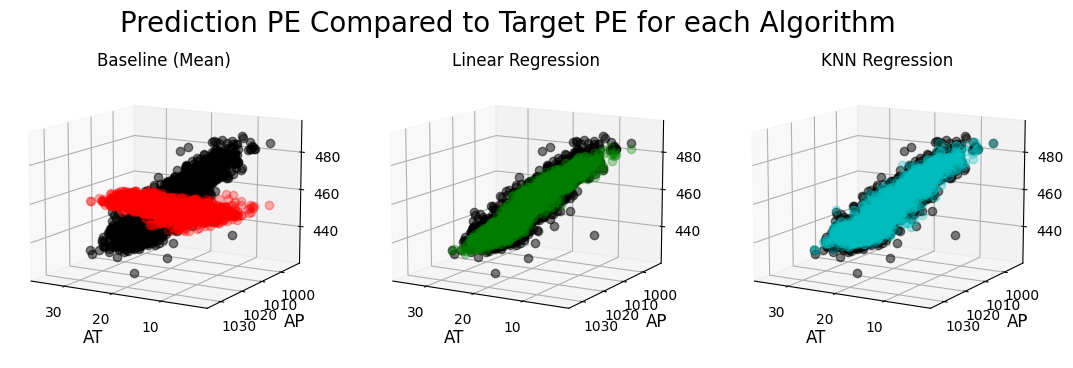

In [27]:
# Finally, we can directly compare the point cloud predictions of each 
# Algorithm on adjacent plots viewed from the same angle.

# Select two of four feature variables by dropping the other two. 
# I have chosen Ambient Pressure (AP) and Temperature (AT)
reduced_data = xtest.drop('RH', axis=1)
reduced_data = reduced_data.drop('V', axis=1)

# reshape  the data so we can split it in the next segment.
X = reduced_data.values.reshape(-1,2)


x = X[:, 0] # x axis is ambient temperature
y = X[:, 1] # y axis is ambient pressure
z = ytest # z axis is energy output






# Create a figure with three subplots
fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

views = [ax1, ax2, ax3]
# plot the target values (grey) and the predictions (red).
for ax in views:
    if ax == ax1:
      alg = dummy_pred
      col = 'r'
      name = 'Baseline (Mean)'
    elif ax == ax2:
      alg = LinReg_pred
      col = 'g'
      name = 'Linear Regression'
    else: 
      alg = knnReg_pred
      col = 'c'
      name = 'KNN Regression'
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.plot(x, y, alg, color=col, zorder=15, linestyle='none', marker='o', alpha=0.3)
    ax.set_xlabel('AT', fontsize=12)
    ax.set_ylabel('AP', fontsize=12)
    ax.set_zlabel('', fontsize=12)
    ax.set_title(name, y = 1)
    ax.locator_params(tight=True, nbins=4, axis='x')
    ax.locator_params(tight=True, nbins=5, axis='x')
# use different perspectives for each sub plot.
ax1.view_init(elev=12, azim=120)
ax2.view_init(elev=12, azim=120)
ax3.view_init(elev=12, azim=120)

# display the mean squared error of the algorithm. 
fig.suptitle('Prediction PE Compared to Target PE for each Algorithm', fontsize=20)

# set the spacing between subplots

fig.subplots_adjust(wspace=0, hspace=0)
fig.show()